## Load data from DBPedia

In [1]:
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data  = pd.read_csv("DBPEDIA_test.csv")

In [3]:
data = data[(data.l1 == "Agent") &(data.l2.isin(["Athlete", "Politician", "Artist", "Actor"]))].reset_index(drop=True)

In [4]:
data = data[["text","l2"]]

In [5]:
data_ath, _ = train_test_split(data[data.l2 == "Athlete"],train_size=250, random_state=561)
data_pol, _ = train_test_split(data[data.l2 == "Politician"],train_size=250, random_state=561)
data_art, _ = train_test_split(data[data.l2 == "Artist"],train_size=250, random_state=561)
data_act, _ = train_test_split(data[data.l2 == "Actor"],train_size=250, random_state=561)

In [6]:
data_raw = pd.concat([data_ath, data_pol, data_art, data_act]).reset_index(drop=True).rename(columns = {"l2":"label"})

In [7]:
data_raw

,text,label
0,Matthew John King (born 25 February 1994) is a...,Athlete
1,"Carlton A. Roles (August 29, 1903 – January 16...",Athlete
2,James Thiessen (born 10 February 1974) is a fo...,Athlete
3,Alan Thomas Woodman (7 June 1955 – 8 May 2014)...,Athlete
4,"David McKinley Henderson (born July 21, 1964) ...",Athlete
...,...,...
995,"Aya Sugimoto (杉本 彩 Sugimoto Aya, born July 19,...",Actor
996,"Misty Rain (born August 10, 1969 in Long Beach...",Actor
997,"Holly Anne Hallstrom (born August 24, 1952) wa...",Actor
998,"Aya Ishizu (石津 彩 Ishizu Aya, born February 22,...",Actor


## NLDA model
### Data Preparation

In [8]:
from settings.common import get_pp_pipeline, load_flat_dataset, save_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
from preprocessing_pipeline.NextGen import NextGen
from settings.common import load_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
import csv
import matplotlib.pyplot as plt
import gensim

In [9]:
pp = get_pp_pipeline(remove_stopwords=True, stem=False, clean_twitter=False, lemmatize=True)

In [10]:
raw_data = pd.DataFrame(data_raw.text)

In [11]:
raw_data.to_csv("dbpedia_raw.csv", header=False, index=False)

In [12]:
dataset = load_flat_dataset("dbpedia_raw.csv", delimiter=' ')

In [13]:
clean_ds = []
for data in dataset:
    tokens = gensim.utils.simple_preprocess(" ".join(data))
    clean_ds.append(tokens)

In [15]:
save_flat_dataset("dbpedia_clean.csv", clean_ds, delimiter=' ')

In [16]:
dataset = []
from src.gdtm.helpers.common import load_flat_dataset
from src.gdtm.models import GTM, NLDA

tnd_path = 'topic-noise-models-source/mallet-tnd/bin/mallet'
lda_path = 'topic-noise-models-source/mallet-lda/bin/mallet'
gtm_path = 'topic-noise-models-source/mallet-gtm/bin/mallet'
dataset = load_flat_dataset("dbpedia_clean.csv")

In [17]:
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [18]:
len(dataset)

2000

### Find the best k for NLDA model

In [37]:
coherence_list = []
for n in range(2, 6):
    model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=n, lda_k=n, tnd_beta1 = int(5*n/6), phi=int(n/3), top_words=30)
    coherence_list.append(model.get_coherent())

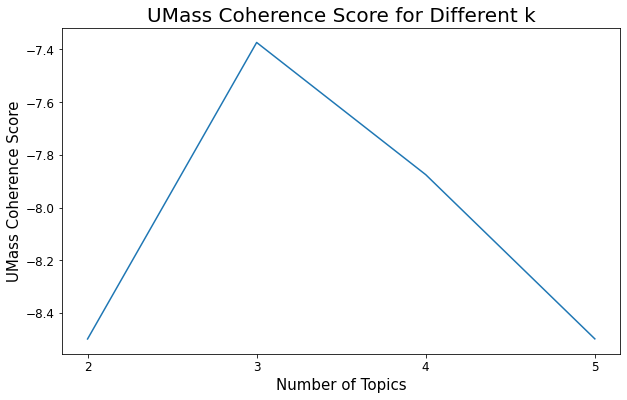

In [39]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 6),coherence_list)
plt.xlabel("Number of Topics", fontsize=15)
plt.ylabel("UMass Coherence Score", fontsize=15)
plt.xticks(range(2, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("UMass Coherence Score for Different k", fontsize=20)
plt.savefig("Coherence_Score.png", dpi=300)

### Get the NLDA topics and noise

In [19]:
model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=20, lda_k=20, tnd_beta1=16, phi=10, top_words=30)

In [20]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('of$the', 1300), ('born', 1259), ('in$the', 736), ('american', 575), ('he$was', 551), ('from$to', 400), ('to$the', 374), ('member', 366), ('served', 359), ('played', 354), ('actress', 344), ('at$the', 308), ('team', 285), ('pornographic', 247), ('actor', 242), ('party', 240), ('politician', 238), ('is$an', 218), ('member$of', 216), ('an$american', 212), ('for$the', 195), ('served$as', 190), ('won', 179), ('was$an', 173), ('elected', 167), ('in$he', 163), ('and$the', 151), ('japanese', 145), ('national', 138), ('in$and', 138), ('he$is', 136), ('governor', 135), ('time', 134), ('player', 133), ('was$the', 130), ('february', 128), ('career', 127), ('august', 126), ('september', 125), ('world', 125), ('state', 124), ('united$states', 123), ('june', 122), ('october', 120), ('january', 119), ('united', 115), ('on$the', 114), ('work', 114), ('professional', 113), ('march', 111), ('university', 111), ('april', 109), ('during$the', 108), ('december', 108), ('one$of', 106), ('comic', 10

In [21]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [22]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [23]:
print(clean_topic)

[['election', 'mayor', 'canadian', 'general', 'appointed', 'council', 'john', 'parliament', 'minister', 'house', 'south', 'term', 'county', 'conservative', 'deputy', 'north', 'local', 'held', 'federal', 'secretary', 'norwegian', 'lawyer', 'leader', 'labour', 'previously', 'assembly'], ['worked', 'york', 'award', 'fashion', 'art', 'including', 'early', 'designer', 'works', 'show', 'family', 'moved', 'business', 'city', 'radio', 'comedy', 'public', 'based', 'made', 'style', 'academy', 'chinese', 'began', 'london', 'white', 'gallery', 'studied', 'received', 'young', 'design'], ['known$for', 'for$his', 'best$known', 'comic$book', 'he$has', 'known$as', 'has$been', 'as$well', 'is$also', 'such$as', 'his$work', 'well$as', 'american$comic', 'has$also', 'and$has', 'born$october', 'is$best', 'also$known', 'october$is', 'hall$of', 'born$is', 'fashion$designer', 'who$has', 'stand$up', 'writer$and', 'born$july', 'book$artist'], ['is$japanese', 'she$was', 'japanese$voice', 'is$the', 'born$september',

In [24]:
with open("dbpedia_NLDA_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

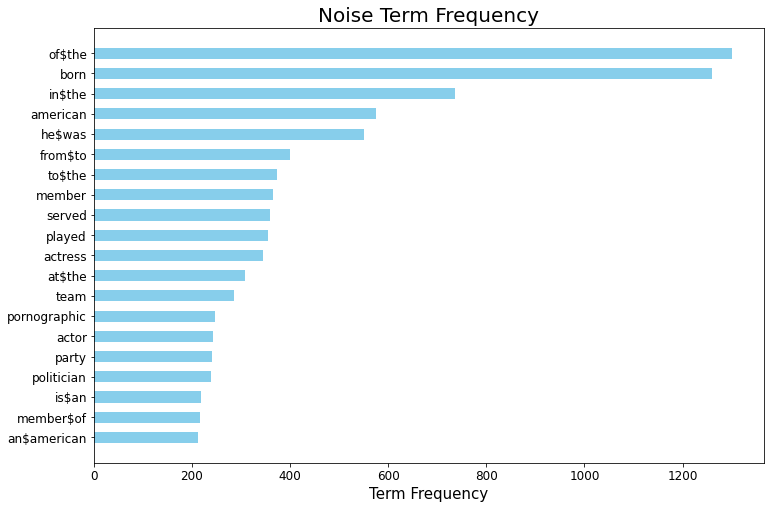

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

### Guided Topic Modeling (GTM)

In [26]:
len(dataset)

2000

In [27]:
dataset = load_flat_dataset("dbpedia_clean.csv")

In [28]:
# add bigrams to the dataset
seed_topics_file = "dbpedia_seed_topics.csv"

ngrams = []
with open(seed_topics_file, 'r') as f:
    for line in f:
        topic = line.strip().split(',')
        for w in topic:
            if '$' in w:
                ngrams.append(w)
dataset = insert_ngrams_flat_from_lists(dataset, ngrams, [])
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [29]:
model = GTM(dataset=dataset, mallet_tnd_path=tnd_path, mallet_gtm_path=gtm_path, 
              tnd_k=20, gtm_k=20, tnd_beta1 = 16, over_sampling_factor=100, phi=10,
              top_words=20,tnd_iterations=1000, gtm_iterations=1000, seed_topics_file=seed_topics_file)

In [30]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('of$the', 1273), ('born', 1107), ('in$the', 905), ('he$was', 656), ('from$to', 399), ('team', 342), ('played', 341), ('to$the', 336), ('american', 314), ('at$the', 308), ('served', 274), ('governor', 263), ('politician', 254), ('pornographic', 248), ('party', 230), ('is$an', 218), ('served$as', 202), ('member', 191), ('elected', 187), ('an$american', 184), ('for$the', 184), ('member$of', 175), ('actress', 169), ('and$the', 159), ('he$is', 159), ('on$the', 148), ('japanese', 145), ('united', 138), ('player', 133), ('national', 129), ('august', 127), ('in$he', 125), ('united$states', 123), ('state', 123), ('actor', 122), ('was$an', 121), ('september', 118), ('january', 117), ('world', 117), ('as$the', 114), ('work', 114), ('university', 111), ('south', 108), ('born$in', 108), ('during$the', 108), ('in$and', 107), ('career', 107), ('series', 107), ('artist', 106), ('october', 104), ('president', 104), ('june', 101), ('professional', 101), ('comics', 100), ('is$japanese', 100), ('

In [31]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [32]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [33]:
print(clean_topic)

[['for$his', 'best$known$for', 'known$as', 'born$june', 'known$for', 'is$also', 'such$as', 'his$work', 'american$comic$book', 'born$is', 'born$october', 'june$is', 'is$best$known', 'october$is', 'writer$and', 'comic$book$artist'], ['won', 'time', 'summer$olympics', 'competed', 'event', 'represented', 'championships', 'european', 'german', 'women', 'international', 'record', 'games', 'number', 'swimmer', 'place', 'states'], ['one$of', 'of$his', 'where$he', 'an$italian', 'into$the', 'he$also', 'italian$painter', 'was$one', 'the$most', 'part$of', 'hall$of', 'of$fame', 'painter$of', 'in$his', 'november$was', 'active$in'], ['the$united', 'from$the', 'house$of', 'university$of', 'was$elected', 'the$university', 'he$served', 'of$representatives', 'the$state', 'the$house', 'elected$as', 'and$served', 'elected$to', 'graduated$from', 'his$death'], ['june', 'july', 'april', 'november', 'february', 'called', 'british', 'john', 'union', 'radio', 'life', 'english', 'brother', 'west'], ['club', 'cham

In [34]:
with open("dbpedia_GTM_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

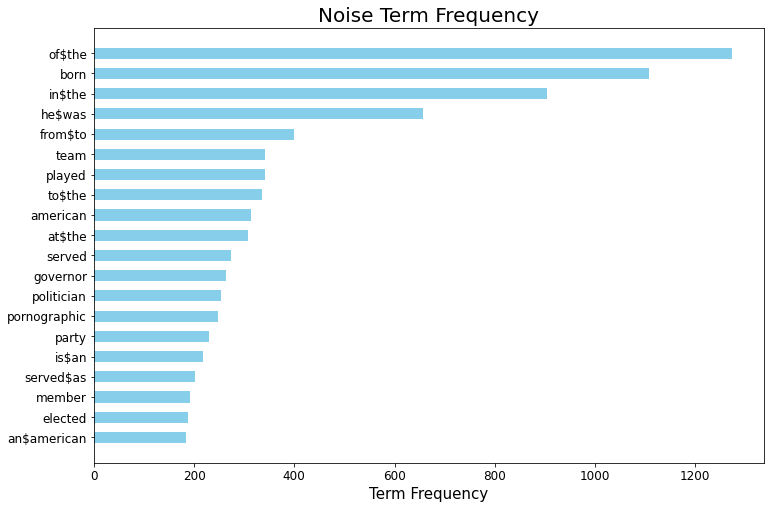

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)